In [2]:
!pip install rembg==2.0.56

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00


# Imports

In [3]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from rembg import new_session, remove

BASE_PATH = '/kaggle/input/key-images/'

# Helper Functions

In [4]:
def load_general_use_model(model_name='isnet-general-use'):
    session = new_session(model_name)
    return session


def remove_bg(input_img):
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    image = remove(input_img, session=session_isnet_general_use, only_mask=False)
    mask = remove(input_img, session=session_isnet_general_use, only_mask=True)

    return np.array(image), np.array(mask)


def get_dataset_images_path(base_path):
    image_names = []
    images_path = []
    for _, _, img_names in os.walk(base_path):
        image_names.extend(img_names)
    
    images_path = [os.path.join(base_path, img_name) for img_name in image_names if "csv" not in img_name]
    return images_path


def plt_img(img_data, cmap='viridis'):
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

# SIFT

In [25]:
images_path = sorted(get_dataset_images_path(BASE_PATH))

key_images = []
for image_path in images_path:

    rgb_img = Image.open(image_path)
    
    image, mask = remove_bg(rgb_img)
    
    _, mask_img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_image = image[y:y+h, x:x+w]
    
    greyed_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    key_images.append(greyed_image)

In [30]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

keypoints, descriptors = [], []
for image in key_images:
    kp, ds = sift.detectAndCompute(image, None)
    keypoints.append(kp), descriptors.append(ds)

In [32]:
match_matrix = []
score_matrix = []

i = 0
for des1 in descriptors:
    match_counts = []
    percentages = []
    
    for des2 in descriptors:
        match_count = len(bf.match(des1, des2))
        match_counts.append(match_count)
        percentages.append(match_count / len(des1))
        
    match_matrix.append(match_counts)
    score_matrix.append(percentages)
    
    print(f"Image {i} done")
    i += 1

Image done
Image done
Image done
Image done
Image done
Image done
Image done
Image done
Image done
Image done


In [41]:
image_names = [path.split('/')[-1].split('.')[0] for path in images_path]

rankings = {}

for i in range(len(image_names)):
    current = []
    for j in range(len(image_names)):
        current.append((image_names[j], score_matrix[i][j]))
        
    current.sort(key=lambda x: x[1], reverse=True)
    rankings[image_names[i]] = current

for key, value in rankings.items():
    print(key, value,'\n')

# HOG

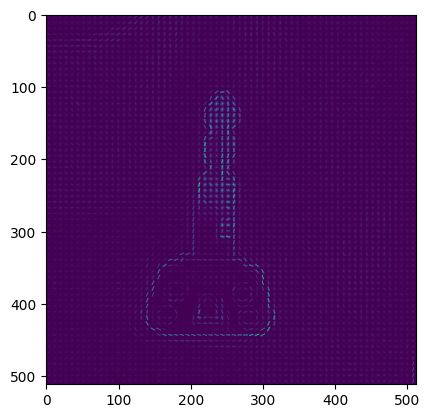

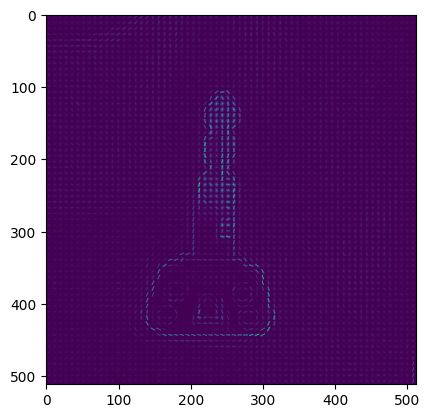

Similarity score: 0.9999999999999939


In [65]:
import numpy as np

from skimage import exposure
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize

from sklearn.metrics.pairwise import cosine_similarity

def compute_hog(image):
    
    # Some constants
    DIM = 512
    PPC = 16
    CPB = 1
    
    # Resize
    image = resize(image, (DIM, DIM), anti_aliasing=True)
    
    # Compute HOG features
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    
    # Enhance contrast of HOG image for visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    plt.imshow(hog_image_rescaled)
    plt.axis('on')
    plt.show()
    
    return fd

def compute_similarity(image1, image2):
    # Compute HOG features for both images
    hog_features1 = compute_hog(image1)
    hog_features2 = compute_hog(image2)
    
    # Compute cosine similarity between HOG feature vectors
    similarity = cosine_similarity([hog_features1], [hog_features2])[0][0]
    return similarity

# Example usage:
# Load images
image1 = imread(f'{BASE_PATH}/8.jpg')
image2 = imread(f'{BASE_PATH}/8.jpg')

# Compute similarity between images
similarity_score = compute_similarity(image1, image2)
print("Similarity score:", similarity_score)

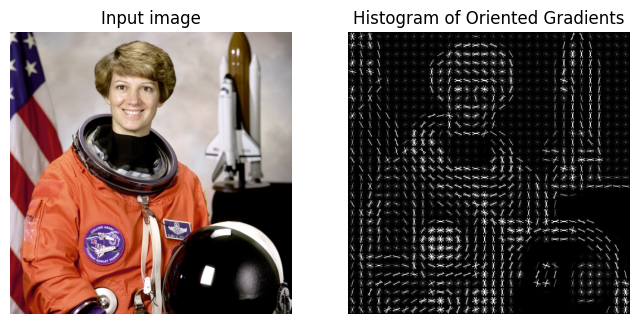

In [54]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

ppc = 16

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(ppc, ppc),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [5]:
import numpy as np

from skimage import exposure
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize

from sklearn.metrics.pairwise import cosine_similarity

def compute_hog(image):
    
    # Some constants
    DIM = 512
    PPC = 16
    CPB = 1
    
    # Resize
    image = resize(image, (DIM, DIM), anti_aliasing=True)
    
    # Compute HOG features
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    return fd

def compute_similarity(fd1, fd2):
    
    # Compute cosine similarity between HOG feature vectors
    return cosine_similarity([fd1], [fd2])[0][0]

In [16]:
image_paths = sorted(get_dataset_images_path(BASE_PATH))
image_names = [path.split('/')[-1].split('.')[0] 
               for path in image_paths]

key_images = []
for image_path in image_paths:

    rgb_img = Image.open(image_path)
    
    image, mask = remove_bg(rgb_img)
    
    _, mask_img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_image = image[y:y+h, x:x+w]
    
#     greyed_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    key_images.append(cropped_image)

In [17]:
key_images[0].shape

(3130, 1845, 4)

In [18]:
fd = [compute_hog(image) for image in key_images]

n = len(fd)

score_matrix = []

for i in range(n):
    row = []
    
    for j in range(n):
        row.append(compute_similarity(fd[i], fd[j]))
    
    score_matrix.append(row)
    
    print(f"Image {i} done")

Image 0 done
Image 1 done
Image 2 done
Image 3 done
Image 4 done
Image 5 done
Image 6 done
Image 7 done
Image 8 done
Image 9 done


In [19]:
rankings = {}

for i in range(len(image_names)):
    current = []
    for j in range(len(image_names)):
        current.append((image_names[j], score_matrix[i][j]))
        
    current.sort(key=lambda x: x[1], reverse=True)
    rankings[image_names[i]] = current

for key, value in rankings.items():
    print(key, value,'\n')

1a [('1a', 1.0000000000000004), ('1b', 0.7924412666308437), ('2a', 0.6123285973134177), ('2b', 0.5844577056089151), ('5', 0.5526571237376209), ('7', 0.5288799037153403), ('8', 0.4694916547824781), ('9', 0.4672567048406767), ('3', 0.3193838301901504), ('4', 0.3045462051512497)] 

1b [('1b', 1.0000000000000007), ('1a', 0.7924412666308437), ('2a', 0.5954226647238481), ('2b', 0.5870454666896106), ('5', 0.5667273725675173), ('7', 0.5477826674961881), ('8', 0.5044183621076799), ('9', 0.49398697432010574), ('3', 0.3029428047476015), ('4', 0.29038013750785774)] 

2a [('2a', 1.0000000000000004), ('2b', 0.7761800253207535), ('1a', 0.6123285973134177), ('1b', 0.5954226647238481), ('5', 0.5703868957360864), ('7', 0.5362827653215525), ('9', 0.4984824091373414), ('8', 0.4760615924879815), ('3', 0.30572389616159906), ('4', 0.2914510807887895)] 

2b [('2b', 0.9999999999999992), ('2a', 0.7761800253207535), ('5', 0.6050590409406521), ('1b', 0.5870454666896106), ('1a', 0.5844577056089151), ('7', 0.575698